# Bayesian Approach Steps
Step 1: Establish a belief about the data, including Prior and Likelihood functions.

Step 2, Use the data and probability, in accordance with our belief of the data, to update our model, check that our model agrees with the original data.

Step 3, Update our view of the data based on our model.

# Functions

In [2]:
#changing datatype
def change_type_to_date(df, to_date):
        # Deal with incorrect data in date column
    for i in to_date:
        df[i] = pd.to_datetime(df[i], errors='coerce')
    return df

  # columns to convert to categorical format
def change_type_to_cat(df, to_cat):
        # Deal with incorrect data in numeric columns
        for i in to_cat:
            df[i] = df[i].astype('category')
        return df

#Plot data
def plot_data(data):
    fig, ax = plt.subplots(figsize=(10, 5))
    data.plot(ax=ax)
    ax.set(ylabel='Islands')
    sns.despine()
    
#KDE plot
def kde_plot(data):
    az.plot_kde(data.values, rug=True)
    plt.yticks([0], alpha=0);
    
    
#prior predictive check
def prior_Predictive_Check(model):
    with model:
        prior_pred = pm.sample_prior_predictive()
    return prior_pred

#prior plot
def Prior_predictive_check_plot(y, prior_pred, y_var):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist([y.mean() for y in prior_pred[y_var]], bins=19, alpha=0.7)
    ax.axvline(data.mean().item())
    ax.set(title='Prior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');
    
#Fitting the model
def fit_model(model, draws=10):
    with model:
    # Inference button (TM)
        trace = pm.sample(draws)
    return trace

#posterior predictive check
def post_Predictive_Check(model, trace, samples=10):
    with model:
        post_pred = pm.sample_posterior_predictive(trace, samples, model=model)
    return post_pred


#post plot
def Post_predictive_check_plot(y, post_pred, y_var):
    _, ax = plt.subplots(figsize=(10, 5))
    ax.hist([y.mean() for y in post_pred['y']], bins=19, alpha=0.5)
    ax.axvline(data.mean().item())
    ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');
        
#posterior plot comparasion with observed data
def compare(post_pred, trace):
    data_ppc = az.from_pymc3(trace=trace, posterior_predictive=post_pred)
    ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
    #ax[0].legend(fontsize=15)
    fig, axs = plt.subplots(3)

# WorkFlow
1) Loading Data

2) Performing EDA

3) Ploting the data and find out the distribution of data

4) Fitting distributions

5) Guassian inference

6) Build the model (decide proir distribution and likelihood distribution on given data)

7) Run the prior predictive check, usually we have less intuition about the prior data, so it is good to always check the prior data. It allows us to make sure the model can generate the types of data we expect to see.

8) Fit the model

9) Assess convergence

10) Summary of the posterior distribution for each parameter.

11) Run posterior predictive check

12) Using Machine Learning for comparing

In [18]:
import pymc3 as pm
import arviz as az
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from fitter import Fitter, get_common_distributions, get_distributions
import warnings
warnings.simplefilter("ignore")

sampler_kwargs = {"chain": 4, "cores":4, "return_inferencedata":True}

### 1) Reading Data

About data:
    Here we will be using covid-19 data from WHO. In data we have 8 columns and 114056 entries.

In [19]:
df = pd.read_excel("new_covid_data.xlsx")
df

,date,country,state,type,confirmed,critical_estimate,days,deaths
0,2020-03-28,Afghanistan,NaN,confirmed,106,5.30,0,2
1,2020-03-29,Afghanistan,NaN,confirmed,114,5.70,1,4
2,2020-03-30,Afghanistan,NaN,confirmed,114,5.70,2,4
3,2020-03-31,Afghanistan,NaN,confirmed,166,8.30,3,4
4,2020-04-01,Afghanistan,NaN,confirmed,192,9.60,4,4
...,...,...,...,...,...,...,...,...
114051,2021-12-10,United Kingdom (total),NaN,confirmed,61445,3072.25,625,457
114052,2021-12-11,United Kingdom (total),NaN,confirmed,61589,3079.45,626,457
114053,2021-12-12,United Kingdom (total),NaN,confirmed,61674,3083.70,627,457
114054,2021-12-13,United Kingdom (total),NaN,confirmed,61776,3088.80,628,458


### 2) Performing EDA

In [3]:
#for each stat of US-> 
#state column is null, so it need to be removed
df.loc[(df.country == 'US'), 'state']

102200   NaN
102201   NaN
102202   NaN
102203   NaN
102204   NaN
          ..
102846   NaN
102847   NaN
102848   NaN
102849   NaN
102850   NaN
Name: state, Length: 651, dtype: float64

Total Confirmed cases with respect to particular country

In [5]:
country_province = df.fillna('N/A').groupby(['country'])['confirmed'].max()

In [6]:
country_province

country
Afghanistan            157858
Albania                204301
Algeria                213288
Andorra                 20136
Angola                  65431
                       ...   
Vietnam               1443648
West Bank and Gaza     464751
Yemen                   10075
Zambia                 211705
Zimbabwe               172012
Name: confirmed, Length: 190, dtype: int64

Top 10 countries with the highest number of cases

In [7]:
# Aggregate records by countries
countries = df.groupby('country')['confirmed'].sum().sort_values(ascending=False)

countries['country'] = countries.index


#Top countries by confirmed cases
top_countries = countries.index[:10]


In [30]:
df.date.min(), df.date.max()

(Timestamp('2020-02-10 00:00:00'), Timestamp('2021-12-14 00:00:00'))

In [33]:
# Aggregate cases by date and country
times_series_cntr = df.groupby(['date','country'])['confirmed'].max()\
                    .groupby(['date','country']).sum()\
                    .reset_index()

# Indexing with Time Series Data
times_series_cntr = times_series_cntr.set_index('date')

In [34]:
times_series_df = times_series_cntr.groupby('date')['confirmed'].sum().reset_index()
times_series_df = times_series_df.set_index('date')

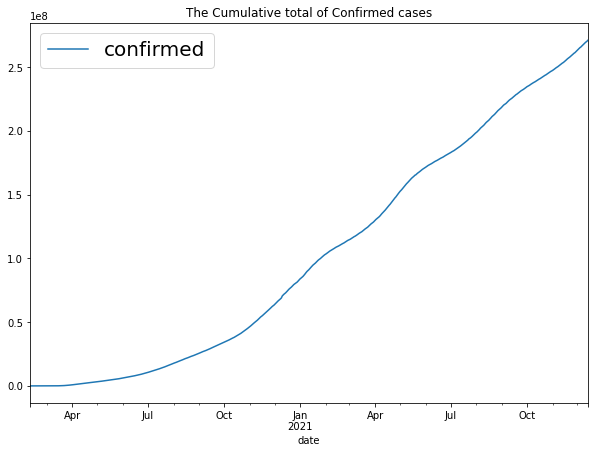

In [36]:
# Cumulative total of Confirmed cases

times_series_df.plot(figsize=(10, 7), title="The Cumulative total of Confirmed cases")
plt.legend(loc=2, prop={'size': 20})
plt.show()

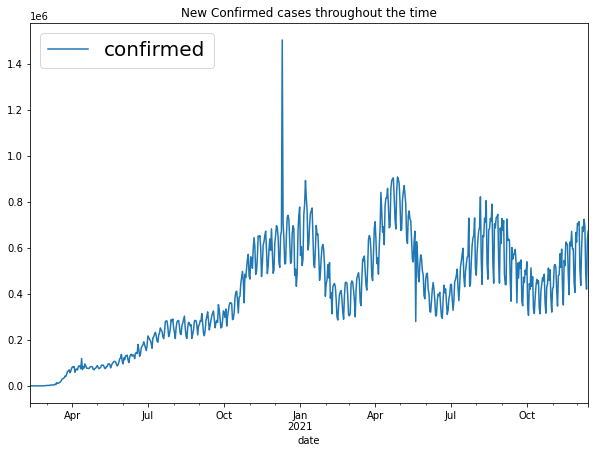

In [37]:
# New Confirmed cases throughout the time

times_series_df.diff().fillna(0).plot(figsize=(10, 7), title="New Confirmed cases throughout the time")
plt.legend(loc=2, prop={'size': 20})
plt.show()

In [38]:
# What is the highest amount of cases reported on one day and when it happened? its 1503553 highest number of cases
#on 20-dec-2020
times_series_df.diff().loc[times_series_df.diff()['confirmed']  == times_series_df.diff().fillna(0).max()['confirmed']]

,confirmed
date,
2020-12-10,1503553.0


We want to consider countries which cross over 100 cases

In [20]:
#countries = df.country.unique()
#n_countries = len(countries)
#df = df.loc[lambda x: (x.Confirmed >= 100)]
df = df.loc[lambda x: (x.days >= 0)]

In [27]:
df.head(10)

,date,country,state,type,confirmed,critical_estimate,days,deaths
0,2020-03-28,Afghanistan,NaN,confirmed,106,5.30,0,2
1,2020-03-29,Afghanistan,NaN,confirmed,114,5.70,1,4
2,2020-03-30,Afghanistan,NaN,confirmed,114,5.70,2,4
3,2020-03-31,Afghanistan,NaN,confirmed,166,8.30,3,4
4,2020-04-01,Afghanistan,NaN,confirmed,192,9.60,4,4
5,2020-04-02,Afghanistan,NaN,confirmed,235,11.75,5,4
6,2020-04-03,Afghanistan,NaN,confirmed,269,13.45,6,5
7,2020-04-04,Afghanistan,NaN,confirmed,270,13.50,7,5
8,2020-04-05,Afghanistan,NaN,confirmed,299,14.95,8,7
9,2020-04-06,Afghanistan,NaN,confirmed,337,16.85,9,7


checking datatypes of columns

In [28]:
df.dtypes

date                 datetime64[ns]
country                      object
state                       float64
type                         object
confirmed                     int64
critical_estimate           float64
days                          int64
deaths                        int64
dtype: object

In this dataset as per country and Russian has highest number of records followed with US, JAPAN, China and India

In [29]:
df['country'].value_counts()

Diamond Princess         674
Korea, South             664
Japan                    663
Italy                    661
Iran                     658
                        ... 
Timor-Leste              307
Laos                     236
Fiji                     233
Saint Kitts and Nevis    186
Summer Olympics 2020     142
Name: country, Length: 190, dtype: int64

Droping some unimportent columns from dataset

In [9]:
df = df.drop('state', axis=1)

checking null values

In [10]:
print(df.isna().sum())
#print("\nThere are 4 Null/Missing values in the dataset\n")

date                 0
country              0
type                 0
confirmed            0
critical_estimate    0
days                 0
deaths               0
dtype: int64


In [6]:
#Removing Duplicate Rows
df.drop_duplicates(inplace=True)

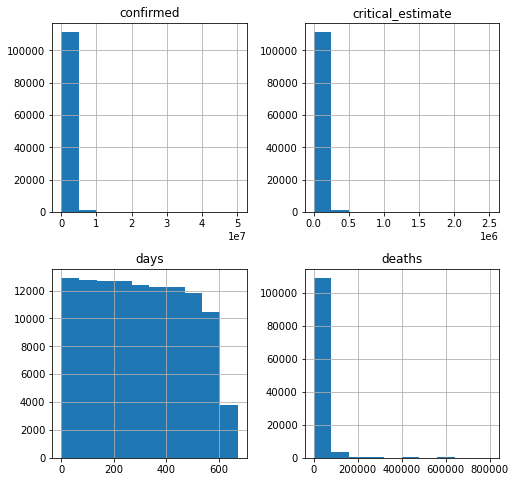

In [33]:
#some stats
df.hist(figsize=(8,8))
plt.show()

### 3) Plotting the data

We will only consider US cases, At first we will look only at the first 50 days since they crossed 100 cases, later we will look at full data

In [21]:
country = 'US'
#df_country = df.loc[lambda x: (x['country'] == country)].iloc[:50]
df_country = df.loc[lambda x: (x.country == country)].iloc[:50]

In [35]:
df_country.head(10)

,date,country,type,confirmed,critical_estimate,days,deaths
102200,2020-03-04,US,confirmed,107,5.35,0,11
102201,2020-03-05,US,confirmed,184,9.20,1,12
102202,2020-03-06,US,confirmed,237,11.85,2,14
102203,2020-03-07,US,confirmed,403,20.15,3,17
102204,2020-03-08,US,confirmed,519,25.95,4,21
102205,2020-03-09,US,confirmed,594,29.70,5,22
102206,2020-03-10,US,confirmed,782,39.10,6,28
102207,2020-03-11,US,confirmed,1147,57.35,7,33
102208,2020-03-12,US,confirmed,1586,79.30,8,43
102209,2020-03-13,US,confirmed,2219,110.95,9,51


Here, we are plotting the dataset and it looks like cases are growing exponentially 

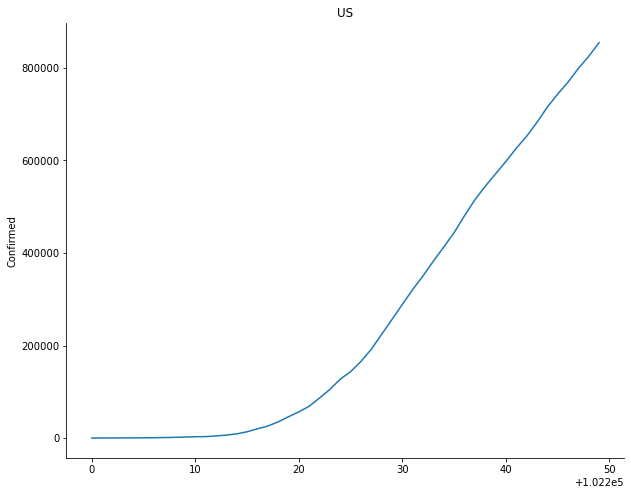

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
df_country.confirmed.plot(ax=ax)
ax.set(ylabel='Confirmed', title=country)
sns.despine()

On the x-axis it shows the days and on y-axis it shows the number of cases. And from above graph we can easily say that cases are increasing exponentially

### 4) Fitting distributions

The next step is to start fitting different distributions and finding out the best-suited distribution for the data.

The steps are:

1) Create a Fitter instance by calling the Fitter()

2) Supply the data and distributions list if you have a basic idea of the distributions that might fit your data

3) Apply the .fit() method

4) Generate the fitted distribution summary using .summary() method

The Fitter class in the backend uses the Scipy library which supports 80 distributions and the Fitter class will scan all of them, call the fit function for you, ignoring those that fail or run forever and finally give you a summary of the best distributions in the sense of sum of the square errors.

,sumsquare_error,aic,bic,kl_div
gamma,3.923938e-10,2998.158766,-1266.802841,inf
lognorm,7.804069e-10,3283.574644,-1232.425366,inf
expon,1.007905e-09,2824.656276,-1223.546695,inf
norm,1.167112e-09,2807.753358,-1216.213797,inf


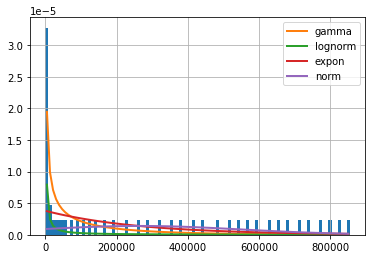

In [142]:
data = df_country.confirmed
#data = data.values
f = Fitter(data,
           distributions=['gamma',
                           'expon',
                          'lognorm',
                          "norm"])
f.fit()
f.summary()

Based on the sumsquare_error value the best distribution for the data is the norm distribution.

### 5) Guassian inference

The KDE plot of the data, shows a Gaussian-like distribution, except for about several dozens of data points that are far away from the mean.

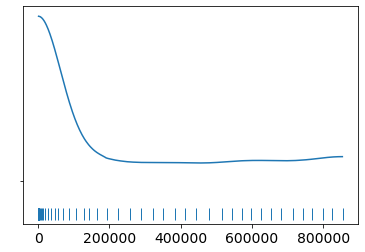

In [143]:
#plotting your data and check the pdf of your data
data = df_country.confirmed
#data = data.values
kde_plot(data)

### 6) Build model

Choices of priors:

μ, mean of a population. Normal distribution, very wide. I do not know the possible values of μ, so i have chosen these values randomly

σ, standard deviation of a population. Can only be positive, therefore use Normal distribution. Again, very wide.

Choices for likelihood function:

y is an observed variable representing the data that comes from a normal distribution with the parameters μ and σ. Draw 1000 posterior samples using NUTS sampling.

In [37]:
#getting time range from days and converting it into values

t = df_country.days.values
confirmed = df_country.confirmed


#here model has 2 things an intercept and slope, it is similar like a linear regression
#Here we  will choose a normal distribution and called that "a", so the first argument  will always 
#have to be the name we give it a mu parameter which is going to be the mean of that normal and a sigma parameter. 
#So here i'm choosing a normal distribution center on zero with a very wide standard with a very wide standard deviation,  
#and then the next for the slope parameter we also  choose a normal distribution

with pm.Model() as model:
    
    
    # Intercept
    a = pm.Normal('a', mu=0, sigma=25)
    
    # Slope
    b = pm.Normal('b', mu=0.1, sigma=0.3)
    
    # Exponential regression
    growth = a * (1 + b) ** t
    
    # Error term    
    eps = pm.HalfNormal('eps')
    
    # Likelihood
    pm.Normal('US', 
              mu=growth, 
              sigma=eps,
              observed=confirmed)
    #trace_g = pm.sample(draws=1000)

### 7) Run prior predictive check

Without even fitting the model to our data, we generate new potential data from our priors. Usually we have less intuition about the parameter space, where we define our priors, and more intution about what data we might expect to see. A prior predictive check thus allows us to make sure the model can generate the types of data we expect to see.

In [38]:
with model:
    prior_pred = pm.sample_prior_predictive()

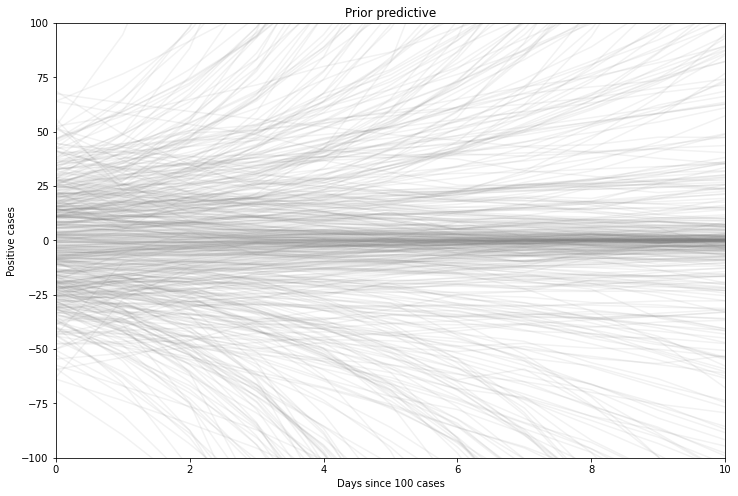

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_pred['US'].T, color="0.5", alpha=.1);
ax.set(ylim=(-100, 100),
       xlim=(0, 10),
       title="Prior predictive", 
       xlabel="Days since 100 cases",
       ylabel="Positive cases");

Here from above chart we can see that from prior check it shows some cases are negative. We can have any negative Cases can not. So we will again apply the model by changing mean and SD values and check the prior again.

In [49]:
t = df_country.days.values
confirmed = df_country.confirmed.values
    
with pm.Model() as model:
    # Intercept
    a = pm.Normal('a', mu=100, sigma=25)
    
    # Slope
    b = pm.Normal('b', mu=0.3, sigma=0.1)
    
    # Exponential regression ( y=ab^t)-> t exponentiating with time dimension
    growth = a * (1 + b) ** t
    
    # Error term for likelihood function
    #we have write halfnormal as we know that SD will be positive 
    eps = pm.HalfNormal('eps')
    
    # Likelihood
    # pm.negativeBinomial
    #pm.NegativeBinomial('US', 
     #            growth, 
      #           alpha=pm.Gamma("alpha",mu=6, sigma=1),
      #           observed=confirmed)
    pm.Lognormal('US', 
                 mu=pm.math.log(growth), 
                 sigma=eps,
                 observed=confirmed)

In [50]:
with model:
    prior_pred = pm.sample_prior_predictive()

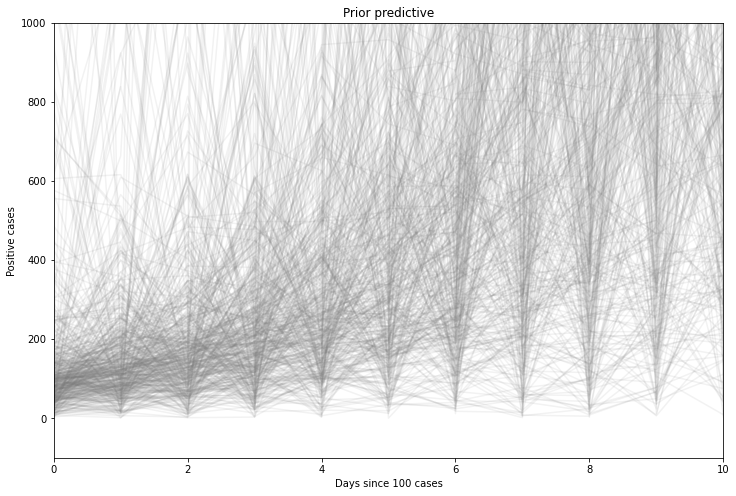

In [146]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_pred['US'].T, color="0.5", alpha=.1);
ax.set(ylim=(-100, 1000),
       xlim=(0, 10),
       title="Prior predictive", 
       xlabel="Days since 100 cases",
       ylabel="Positive cases");

By changing the value of mean and SD now we are not getting negative values. so now in next step we will fit the model

### 8) Fit model (hit the Inference Button)

In [7]:
with model:
    # Inference button (TM)
    trace = pm.sample(cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 376 seconds.


### 9) Assess convergence

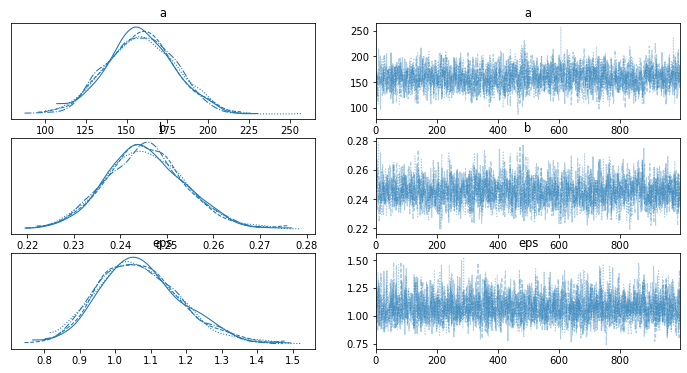

In [41]:
with model:
    pm.traceplot(trace);

On the left, we have a KDE plot, — for each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is.

On the right, we get the individual sampled values at each step during the sampling. From the trace plot, we can visually get the plausible values from the posterior.

There are a couple of things to notice here:

Our sampling chains for the individual parameters (left) seem well converged and stationary (there are no large drifts or other odd patterns).

The maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters.

We can plot a joint distributions of parameters.

Got error No model on context stack. trying to find log_likelihood in translation.


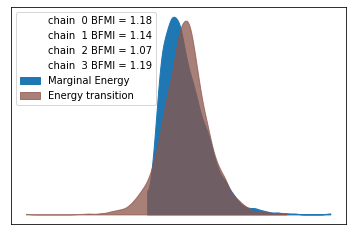

In [43]:
pm.plot_energy(trace);

In [105]:
#az.plot_pair(trace, kind='kde', fill_last=False);

I don’t see any correlation between these two parameters. This means we probably do not have collinearity in the model. This is good.

### 10) Summary of the posterior distribution for each parameter

In [106]:
az.summary(trace)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,128.587,9.762,111.610,148.254,0.225,0.159,1885.0,2325.0,1.0
b,0.330,0.028,0.277,0.381,0.001,0.000,2032.0,2530.0,1.0
eps,0.402,0.042,0.326,0.480,0.001,0.001,2598.0,2542.0,1.0


The important parameters to look from above table are mean, SD and r_hat which should always be close to 1

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


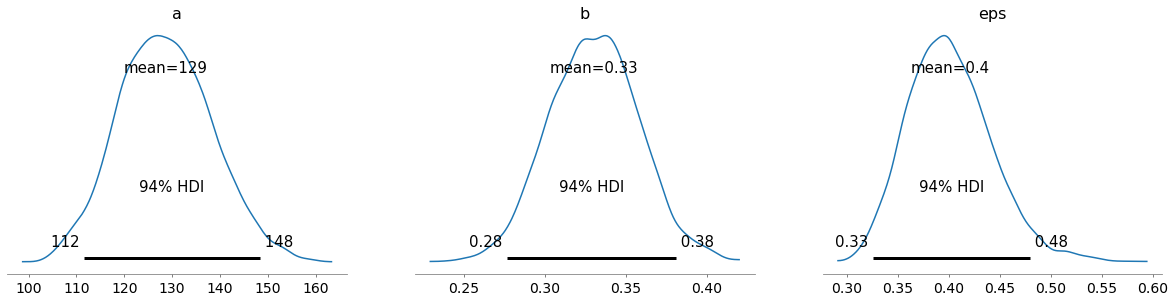

In [107]:
az.plot_posterior(trace);

Here we can interpret as such that there is 94% probability the belief is between 112 and 148 for the mean.

### 11) Run posterior predictive check

In [8]:
with model:  
    # Draw sampels from posterior predictive
    post_pred = pm.sample_posterior_predictive(trace)

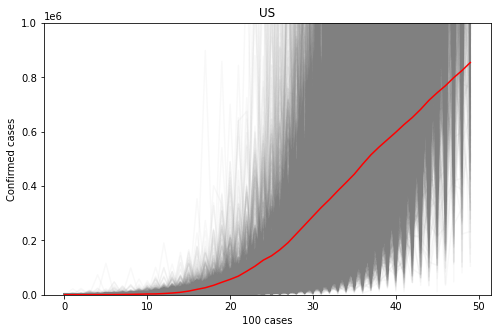

In [54]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(post_pred['US'].T, color='0.5', alpha=.05);
ax.plot(confirmed, color='r')
ax.set(xlabel='100 cases', ylabel='Confirmed cases', 
       ylim=(0, 1_000_000), title=country);

Posterior residuals 

In [56]:
#fig, ax = plt.subplots(figsize=(8, 5))
#resid = post_pred["eps"] - confirmed
#ax.plot(resid.T, color='0.5', alpha=.05);
#ax.plot(confirmed, color='r')
#ax.set(xlabel='Cases', ylabel='Residual', 
 #      ylim=(0, 1_000_000), title=country);

# ML

In [29]:
country = 'US'
#df_country = df.loc[lambda x: (x['country'] == country)].iloc[:50]
df_country = df.loc[lambda x: (x.country == country)].iloc[:50]

In [53]:
df_country['confirmed'].dtype

dtype('int64')

In [42]:
# convert the 'Date' column to datetime format
df_country['date']= pd.to_datetime(df_country['date'])

In [ ]:
# convert the 'Date' column to datetime format
df_country['confirmed']= pd.to_datetime(df_country['confirmed'])

In [55]:
df_country['confirmed']= df_country['confirmed'].astype(float)

In [30]:
df_country.head(4)

,date,country,state,type,confirmed,critical_estimate,days,deaths
102200,2020-03-04,US,NaN,confirmed,107,5.35,0,11
102201,2020-03-05,US,NaN,confirmed,184,9.20,1,12
102202,2020-03-06,US,NaN,confirmed,237,11.85,2,14
102203,2020-03-07,US,NaN,confirmed,403,20.15,3,17


In [44]:
#df_country = df_country.drop('state', axis=1)

In [46]:
df_country = df_country.drop('country', axis=1)
df_country = df_country.drop('type', axis=1)

In [27]:

df_country = df_country.drop('critical_estimate', axis=1)
df_country = df_country.drop('days', axis=1)
df_country = df_country.drop('deaths', axis=1)

In [47]:
df_country.head(4)

,date,confirmed,critical_estimate,days,deaths
102200,2020-03-04,107,5.35,0,11
102201,2020-03-05,184,9.20,1,12
102202,2020-03-06,237,11.85,2,14
102203,2020-03-07,403,20.15,3,17


In [56]:
X = df_country['date'].values.reshape(-1,1) #get a copy of dataset exclude last column
y = df_country['confirmed'].values.reshape(-1,1) #get array of dataset in column 1st

In [57]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)

In [58]:
# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [59]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

[-3.54648375e+08]
[[2.23869717e-10]]


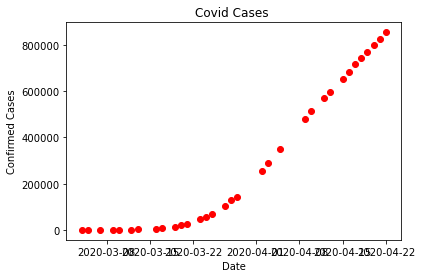

In [63]:
# Visualizing the Training set results
viz_train = plt
viz_train.scatter(X_train, y_train, color='red')
#viz_train.plot(X_train, regressor.predict(X_train), color='blue')
viz_train.title('Covid Cases ')
viz_train.xlabel('Date')
viz_train.ylabel('Confirmed Cases')
viz_train.show()

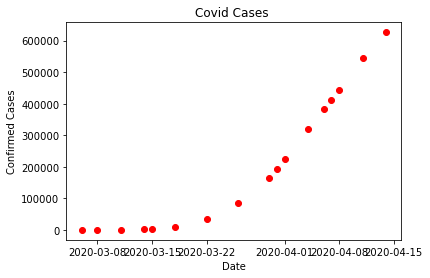

In [64]:
# Visualizing the Test set results
viz_test = plt
viz_test.scatter(X_test, y_test, color='red')
#viz_test.plot(X_train, regressor.predict(X_train), color='blue')
viz_train.title('Covid Cases ')
viz_train.xlabel('Date')
viz_train.ylabel('Confirmed Cases')
viz_test.show()

# Summary
In this experiment, both bayesian and ML work mostly same for predicting values. You can see the graphs from both methods, which are predicting the exponential growth correctly.
Observation:
ML works faster than MCMC. I have found sampling jax, which can work faster in MCMC. But can't apply due to the lack of time.
MCMC can work good with small dataset. I have used 114056k data , maybe , it took too long.